# Celebrity Face Detection with Computer Vision
### Advanced Topics in Data Science (AC209B), Harvard University
Alison Yao, Luis Henrique Simplicio Ribeiro, Isidora Diaz, Elie Attias, Isabella Bossa 

Table of Contents:
1. Motivation, Context and Framing
2. Data Description and Handling
 -  Potential Issues
 - Pre-Processing
3. Exploratory Data Analysis
4. Modeling Approach
 - Structure of Data
 - Image Cropping
 - Final Model
 - Results
5. Conclusion and Future Work
6. References

## Motivation, Context and Framing

Since AlexNet won the ImageNet visual recognition challenge in 2012, neural networks underwent an explosion in popularity so big and influential that our world continues to be reshaped and revolutionized by it. Computers had until then been highly effective with numerical and tabular data but not of much use when it came to image recognition. AlexNet’s incredible success in the 2012 competition, however, turned the standards of the time upside down and paved the way for the future we are living in now: one where computer vision has made such large advances that they has become an important part of our daily lives and a powerful tool in fields ranging from healthcare to marketing to transportation to e-commerce and more. 

Computer vision focuses on enabling machines to interpret and understand visual information from the world around them. It aims to analyze and interpret images and videos and extract meaningful information from them. One of the many applications of computer vision is facial recognition which, as  its name suggests, is a biometric technology that identifies or verifies the identity of an individual by analyzing their facial features. It works by capturing an image of a face and then comparing it against a database of known faces. This is usually achieved by training a deep neural network to map the images to vectors and compare these vectors using a distance metric.

Computer vision facial recognition have been particularly influential in media and entertainment. They have driven new forms of content creation, distribution and consumption and has enabled the sector to create more engaging, immersive and personalized content. Digital media has become so popular and prevalent, that Americans are reported to spend, on average, more than 13 hours per day on some form digital media, including movies, music or video games. In the case of the former, online streaming services started gaining significant momentum in the early 2010s and were present in 78% of US households by 2022. All top players are engaged in a fiece competition with each other and strive to provide unique benefits and features that set them apart from other streamings services. Amazon Prime Video is the current market leader, with 21% of the market share in Q1 2023 according to JustWatch.

One of the unique features of Amazon Prime Video is the display of a list of actors that appear on the scene when pausing a film or TV show. Many of us are big film and TV enthusiasts and have spent more time than we would like to admit wondering where exactly we have seen an actor or actress before. We found the Amazon Prime Video solution to be a fun, practical and elegant feature that, in addition, could allow us to implement some of the knowledge acquired during class, get outside of our comfort zones, and learn a great deal about facial detection and recognition. In our project, we aim to replicate this feature, answering the following question: is it possible to utilize transfer learning to develop our own facial recognition model capable of accurately categorizing celebrity faces sourced from the CelebA dataset?


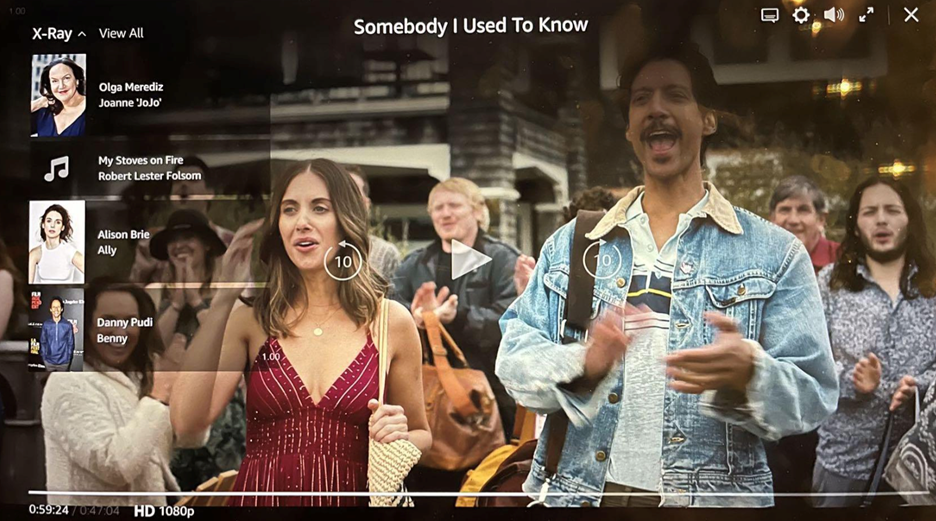

## Data Description and Handling

It is necessary to install two modules (`ultralytics` and `omegaconf`) and import several packages, including `pandas`, `matplotlib`, `seaborn`, `tensorflow`, `keras`, and others (listed in the code below).

In [1]:
# install necessary modules
!pip install ultralytics
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.2/566.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=a655befc58142fe57d45dbaf5c25efaf0037a10b93ccc73efefb9f74236abaf8
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [59]:
# importing necessary modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import cv2
import os
import tqdm
import time
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import layers, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import Xception, MobileNetV2, resnet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import rcParams
import gdown
from google.colab import drive
from google.colab.patches import cv2_imshow
from glob import glob
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO

# mount drive
drive.mount('/content/drive')

# set seed
np.random.seed(123)

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# IMPORTANT: update path if running locally
mypath = "/content/drive/MyDrive/AC209B_project/Final_Notebook_Submission/"

In [4]:
# dataframes
url = "https://drive.google.com/file/d/1a2UICY52cuHRmVg03CwDTdi2TDe5TV9N/view?usp=share_link"
attr = "list_attr_celeba.csv"
gdown.download(url, attr, quiet=False, fuzzy=True)
df_attr = pd.read_csv(attr)
df_attr = df_attr.replace({-1: 0, 1: 1})

url = "https://drive.google.com/file/d/1kXi0PlMJ3T7zfRg6seCPjhB0maYLsSE1/view?usp=share_link"
identity = "identity_CelebA.txt"
gdown.download(url, identity, quiet=False, fuzzy=True)
df_identity = pd.read_csv(identity, sep=" ", header=None)
df_identity = df_identity.rename(columns={0:"image", 1:"ID"})

Downloading...
From: https://drive.google.com/uc?id=1a2UICY52cuHRmVg03CwDTdi2TDe5TV9N
To: /content/list_attr_celeba.csv
100%|██████████| 24.9M/24.9M [00:00<00:00, 38.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kXi0PlMJ3T7zfRg6seCPjhB0maYLsSE1
To: /content/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 177MB/s]


We used the [Large-Scale CelebFaces Attributes](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (CelebA) dataset. CelebA is a large-scale face attributes dataset with more than 202,599 images of 10,177 celebrities, each with 40 attribute annotations.  CelebA originated from the Multimedia Laboratory at the Chinese University of Hong Kong and is popular dataset containing large diversities, large quantities and rich annotatinos. Moreover, the celebrity images in it cover large pose variations and background clutter.

The original version of the dataset does not contain the identities of the celebrities in the images, but we were able to obtain these after contacting the authors.

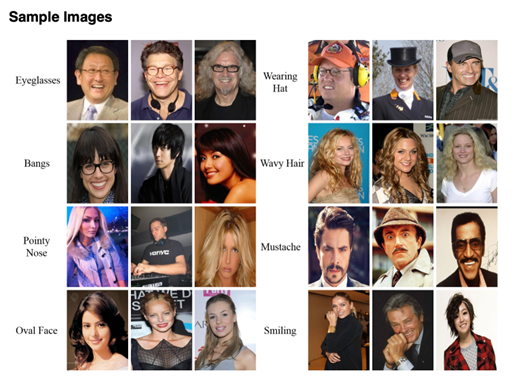

CelebA contains multiple data files including in-the-wild images, cropped and aligned images, recommended partitioning of images into test, train and evaluation sets, bounding box information, and image landmarks and coordinates. Among all these, we used the in-the-wild dataset for our model as it contained the type of images we will encounter in our final task - where we intend to classify celebritiy faces in movies, i.e. "in the wild".

### Potential Issues
When evaluating our data, we found a number of potential issues:
1. Some celebrities were present in as many as 35 images, while others only had 1 picture that included them. This may cause our model to perform better for celebrities with more images. However, we also expect celebrities with more images to be more well-known and do not believe this imbalance would cause any major problem.

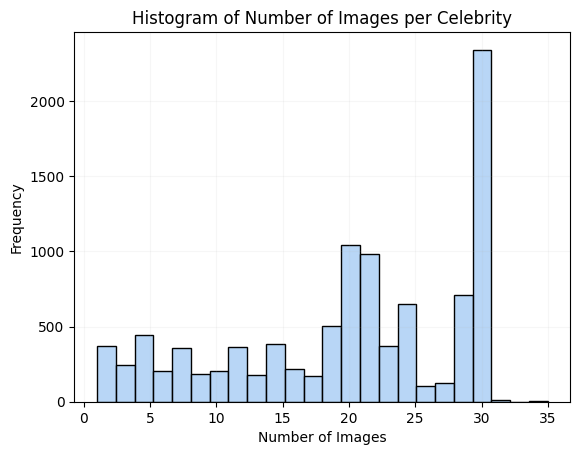

In [5]:
df_temp = df_identity.groupby("ID").count().reset_index()
sns.histplot(df_temp, x="image", color="#a1c9f4")
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Images per Celebrity")
plt.grid(alpha=0.1);

2. Slightly over 58% of the observations belonged to female celebrities, while the remaining 42% were from male celebrities. Despite the slight class imbalance, the proportions were relatively close to those of the general population and the difference between the two ratios was not too large, so we believe this is not be a problem.

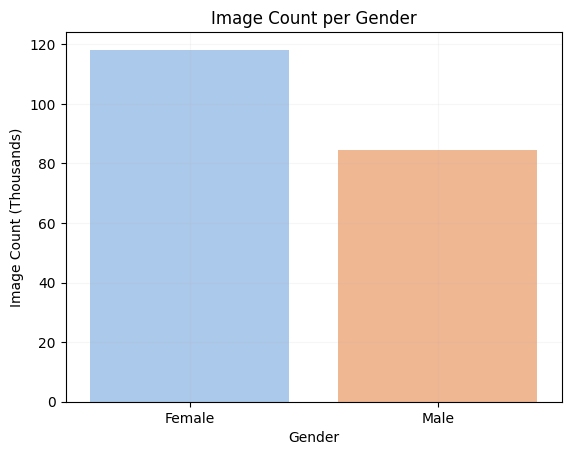

In [6]:
df_temp2 = df_attr[["Male", "image_id"]].groupby("Male").count().reset_index()
df_temp2["Male"] = df_temp2["Male"].replace({0:"Female", 1:"Male"})
df_temp2["image_id"] = df_temp2["image_id"] / 1000
df_temp2.rename(columns={"image_id": "Count", "Male": "Gender"}, inplace=True)

sns.barplot(df_temp2, x="Gender", y="Count", palette="pastel")
plt.ylabel("Image Count (Thousands)")
plt.title("Image Count per Gender")
plt.grid(alpha=0.1);

3. Some attributes were more present than others. For example, less than 5% of the images contain bald celebrities. This potential domain shift would only be an issue if we were planning to use the model with a subset of celebrities that had a different distribution of the target attribute - and we are not.

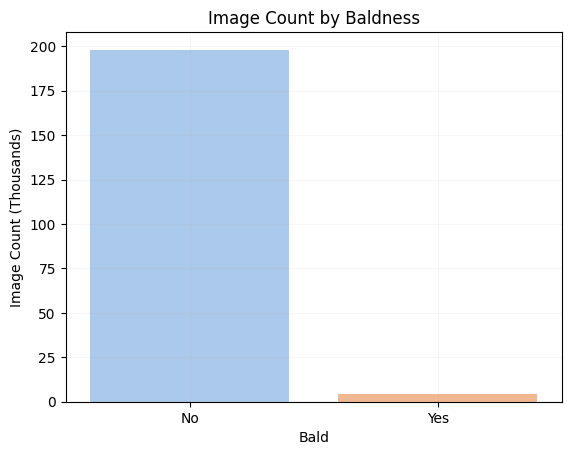

In [7]:
df_temp2 = df_attr[["Bald", "image_id"]].groupby("Bald").count().reset_index()
df_temp2["Bald"] = df_temp2["Bald"].replace({0:"No", 1:"Yes"})
df_temp2["image_id"] = df_temp2["image_id"] / 1000
df_temp2.rename(columns={"image_id": "Count"}, inplace=True)

sns.barplot(df_temp2, x="Bald", y="Count", palette="pastel")
plt.ylabel("Image Count (Thousands)")
plt.title("Image Count by Baldness")
plt.grid(alpha=0.1);

4. We used contrastive learning to train the model, making use of positive/negative pairs of images where a pair composed of two pictures from the same celebrity is a positive pair and a pair of two pictures from two different celebrities is a negative pair. There were 44 celebrities with a single image on the dataset, so we were unable to include them during our training. This, however, does not pose a problem given the large sample size we have.

In [8]:
single_image = np.sum(df_temp[df_temp["image"] < 2])["image"]
print(f"There are {single_image} celebrities with a single image in CelebA")

There are 44 celebrities with a single image in CelebA


5. It is difficult to identify outliers in the dataset without manually exploring it. In this case, given the large number of images, it was impossible for us to perform a visual inspection of all the pictures. However, we explored the distribution of the 40 annotated attributes per image in the Exploratory Data Analysis section.

### Pre-Processing
To identify celebrities, we needed to first be able to detect their faces. To do this, we located the face for each celebrity in the in-the-wild images using You Only Look Once (YOLO), a detection algorithm known for its speed and accuracy. YOLO, which we learned during the Advanced Sections, is widely popular and performs single-shot detection. 

In [14]:
# unzips the image data locally
url = "https://drive.google.com/file/d/10zLhXD9Wax7w-fZ2XMFlhu9JVh1QdCAE/view?usp=share_link"
output = "img_celeba.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

!unzip img_celeba.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=10zLhXD9Wax7w-fZ2XMFlhu9JVh1QdCAE
To: /content/img_celeba.zip
100%|██████████| 10.4G/10.4G [00:49<00:00, 209MB/s]


Example of an in-the-wild image.


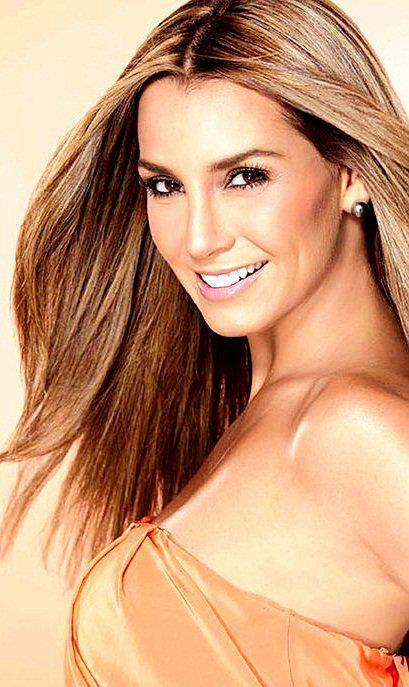

In [15]:
img = cv2.imread('img_celeba/000001.jpg')
print("Example of an in-the-wild image.")
cv2_imshow(img)

In [16]:
# Input Images
data_img = glob('img_celeba/*.jpg')

We used a Yolo v8 model trained to detect faces, obtaining bounding boxes for celebrities' faces in each image.

In the example below, YOLO identified one face in the image and is 67% sure about it.

Downloading...
From: https://drive.google.com/uc?id=1R5d_OpNfPpl2JjE9IIJikAeP2Jy62zR_
To: /content/yolov8n-face.pt
100%|██████████| 6.25M/6.25M [00:00<00:00, 21.3MB/s]

WARNING ⚠️ NMS time limit 0.550s exceeded
0: 640x384 1 face, 50.5ms
Speed: 19.6ms preprocess, 50.5ms inference, 2282.2ms postprocess per image at shape (1, 3, 640, 640)



Bouding box for face found by YOLO for example image.


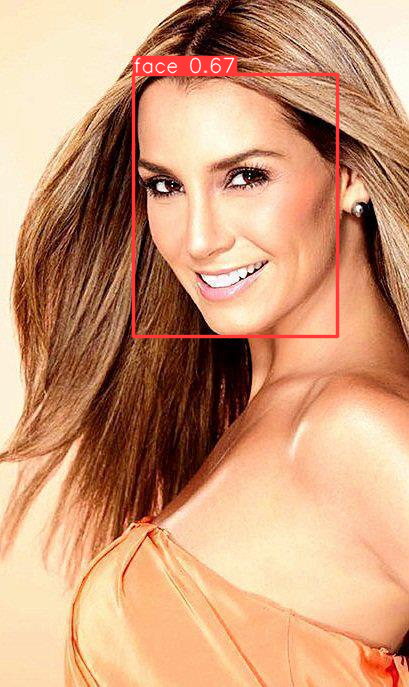

In [17]:
# Yolo v8
url = "https://drive.google.com/file/d/1R5d_OpNfPpl2JjE9IIJikAeP2Jy62zR_/view?usp=share_link"
yolo = "yolov8n-face.pt"
gdown.download(url, yolo, quiet=False, fuzzy=True)
yolov8 = YOLO(yolo)
file_path = "img_celeba/000001.jpg"
image = cv2.imread(file_path)
results = yolov8(image)
annotated_frame = results[0].plot()

print("\nBouding box for face found by YOLO for example image.")
cv2_imshow(annotated_frame);

We followed this procedure for a subset of the images (we were unable to run it on the entire dataset due to resource constraints). In the end, YOLO was unable to find a face in 124 cases. 

In [18]:
url = "https://drive.google.com/file/d/1_VNRMhQuPB-Y2-QcPn9nB7wQzftrzu4M/view?usp=share_link"
paired_data = "paired_data_7k14k.csv"
gdown.download(url, paired_data, quiet=False, fuzzy=True)

paired_data_df = pd.read_csv(paired_data)
X1_names = paired_data_df['X1'].apply(lambda x: x.split('/')[-1])
X2_names = paired_data_df['X2'].apply(lambda x: x.split('/')[-1])
image_set = pd.concat([X1_names, X2_names], axis=0).apply(lambda x: 'img_celeba/'+x)

Downloading...
From: https://drive.google.com/uc?id=1_VNRMhQuPB-Y2-QcPn9nB7wQzftrzu4M
To: /content/paired_data_7k14k.csv
100%|██████████| 1.33M/1.33M [00:00<00:00, 135MB/s]


In [19]:
RUN = False

# Loop through all images and get the bounding box of the faces
if RUN:
  x1s, y1s, x2s, y2s = [], [], [], []
  no_face_count = 0
  no_face = []
  for file_path in set(image_set):
    image = cv2.imread(file_path)
    idx = int(file_path.split('/')[-1].split('.')[0]) - 1
    print(file_path)
    results = yolov8(image)
    if len(results[0].boxes) == 0:
      x1, y1, x2, y2 = 0, 0, 0, 0
      no_face_count += 1
      no_face.append(file_path)
    else:
      bounding_box = results[0].boxes.xyxy[0]
      x1, y1, x2, y2 = bounding_box
      x1, y1, x2, y2 = x1.item(), y1.item(), x2.item(), y2.item()
    df_identity.at[idx, 'x1'] = x1
    df_identity.at[idx, 'y1'] = y1
    df_identity.at[idx, 'x2'] = x2
    df_identity.at[idx, 'y2'] = y2

We stored the results in a CSV file and, for the sake of time and replicability, we read from the file during subsequent runs. 

In [20]:
# store results in csv file
# identity_df.to_csv('/content/drive/MyDrive/AC209B_project/Data/identity_box.csv', index=False)

url = "https://drive.google.com/file/d/1uv-E7iC7Kekd6HnaoIwBXy0gZezUeBwP/view?usp=share_link"
identity_box = "identity_box.csv"
gdown.download(url, identity_box, quiet=False, fuzzy=True)

# read results into a new dataframe
df_identity_box = pd.read_csv(identity_box, index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1uv-E7iC7Kekd6HnaoIwBXy0gZezUeBwP
To: /content/identity_box.csv
100%|██████████| 7.92M/7.92M [00:00<00:00, 30.9MB/s]


We removed the 124 observations where YOLO was unable to detect a face and cropped the remaining images. For the latter, we used the bouding box coordinates found by YOLO during the cropping, and ended up with a collection of images depicting celebrities' faces.

In [21]:
# remove observations where YOLO was unable to detect a face
df_identity_box.drop(df_identity_box[(df_identity_box['x1']== 0) & (df_identity_box['x2']== 0)].index, inplace = True)
assert len(df_identity_box[(df_identity_box['x1']== 0) & (df_identity_box['x2']== 0)]) == 0

df_identity_box.drop(df_identity_box[np.isnan(df_identity_box["x1"]) & np.isnan(df_identity_box["x2"])].index, inplace = True)

# store results in dataframe
# df_identity_box.to_csv('/content/drive/MyDrive/AC209B_project/Data/identity_box_cleaned.csv')


Example of a cropped image based on YOLO results.


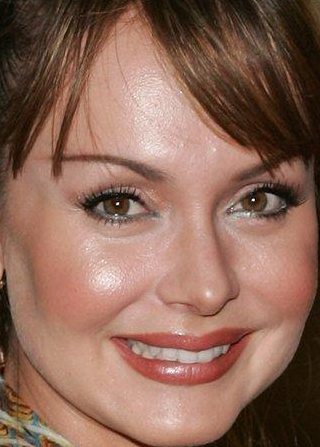

In [22]:
# double check cropped faces
row = df_identity_box.iloc[[0]]
image_path = 'img_celeba/' + row['image'].item()
x1, y1, x2, y2 = int(row['x1'].item()), int(row['y1'].item()), int(row['x2'].item()), int(row['y2'].item())
image = cv2.imread(image_path)
cropped = image[y1:y2, x1:x2 , :]
print("\nExample of a cropped image based on YOLO results.")
cv2_imshow(cropped)

## Exploratory Data Analysis

As mentioned earlier, it is difficult to identify outliers within the pictures without visually inspecting the images. However, this is a practically impossible task given the sheer size of the data. For this reason, we analyzed the image shape and feature annotations instead for our EDA.

To start, we examined the image shape and channel values of the images in the dataset. We found that the former varied drastically throughout the dataset. Therefore, for the in-the-wild celebrity identification part of our model, we resized all images down to the same size ($128 \times 128$ pixels).

In [23]:
# obtain image shape and channel values
# this code takes a long time to run, so we stored results in a dataframe and 
# loaded them back in subsequent runs
RUN = False
if RUN:
  hs = []
  ws = []
  reds = []
  greens = []
  blues = []
  for img_path in data_img:
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    red = np.sum(img[:,:,0]) / (h*w)
    green = np.sum(img[:,:,1]) / (h*w)
    blue = np.sum(img[:,:,2]) / (h*w)
    hs.append(h)
    ws.append(w)
    reds.append(red)
    greens.append(green)
    blues.append(blue)

  # create dataframe with results
  df_image_metadata = pd.DataFrame(list(zip(hs, ws, reds, greens, blues)),
                                   columns=["height", "width", "red", "green", "blue"])

  # store results in dataframe
  df_image_metadata.to_csv(mypath + 'Data/image_metadata.csv')

In [24]:
# load results from previous run
url = "https://drive.google.com/file/d/1wD1IxqdZZIBtjkyncgkqJoObkTj6dZB2/view?usp=share_link"
image_metadata = "image_metadata.csv"
gdown.download(url, image_metadata, quiet=False, fuzzy=True)

df_image_metadata = pd.read_csv(image_metadata, index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1wD1IxqdZZIBtjkyncgkqJoObkTj6dZB2
To: /content/image_metadata.csv
100%|██████████| 14.0M/14.0M [00:00<00:00, 109MB/s] 


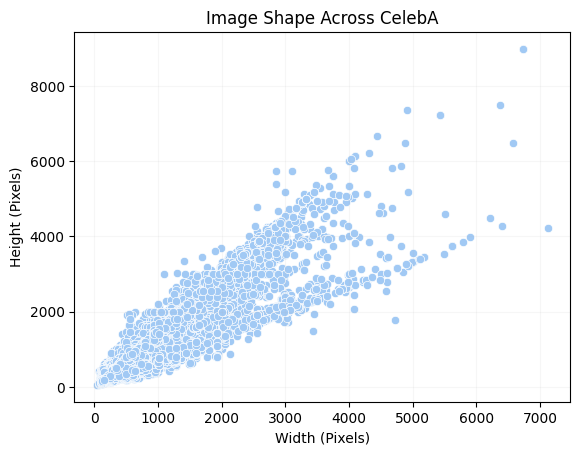

In [25]:
sns.scatterplot(x=df_image_metadata["width"], y=df_image_metadata["height"], color="#a1c9f4")
plt.grid(alpha=0.1)
plt.xlabel("Width (Pixels)")
plt.ylabel("Height (Pixels)")
plt.title("Image Shape Across CelebA");

As for RGB channels, we observed that blue is the predominant channel, with higher levels of pixel intensity than the other two. Green has, on average, the second highest intensity, followed by red in the last place.

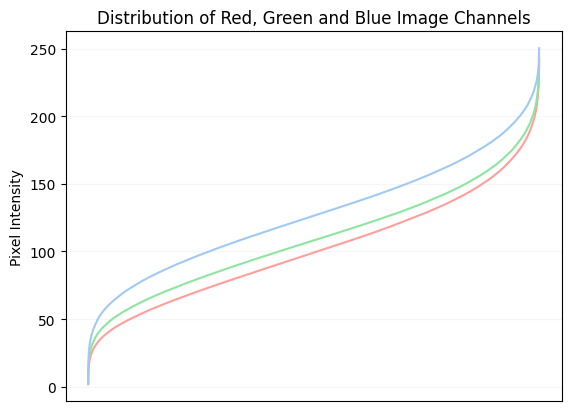

In [26]:
fig, ax = plt.subplots()
sns.lineplot(x=range(len(df_image_metadata)), y=df_image_metadata["red"].sort_values(), color="#ff9f9b", ax=ax)
sns.lineplot(x=range(len(df_image_metadata)), y=df_image_metadata["green"].sort_values(), color="#8de5a1", ax=ax)
sns.lineplot(x=range(len(df_image_metadata)), y=df_image_metadata["blue"].sort_values(), color="#a1c9f4", ax=ax)
plt.ylabel("Pixel Intensity")
ax.set(xlabel=None)
ax.set_xticks([])
plt.grid(alpha=0.1)
plt.title("Distribution of Red, Green and Blue Image Channels");

We additionally analyzed a subset of attributes from CelebA. These include physical characteristics present as annotations for every image like being bald, being chubby, having  a big nose, and so on. Our goal in doing this was to identify the distribution of different attributes across the dataset.

In [27]:
cols = ['Bald', 'Big_Nose', 'Black_Hair', 'Blurry', 'Chubby', 'Eyeglasses', 
        'Gray_Hair', 'Heavy_Makeup', 'Male', 'No_Beard', 'Pale_Skin', 'Smiling', 
        'Wavy_Hair', 'Wearing_Hat', 'Young']
col_names = ['Bald', 'Big Nose', 'Black Hair', 'Blurry', 'Chubby', 'Eyeglasses', 
        'Gray Hair', 'Heavy Makeup', 'Male', 'No_Beard', 'Pale Skin', 'Smiling', 
        'Wavy Hair', 'Wearing Hat', 'Young']

df_attr_subset = df_attr[cols]
df_attr_subset = df_attr_subset.replace({0: "No", 1: "Yes"})

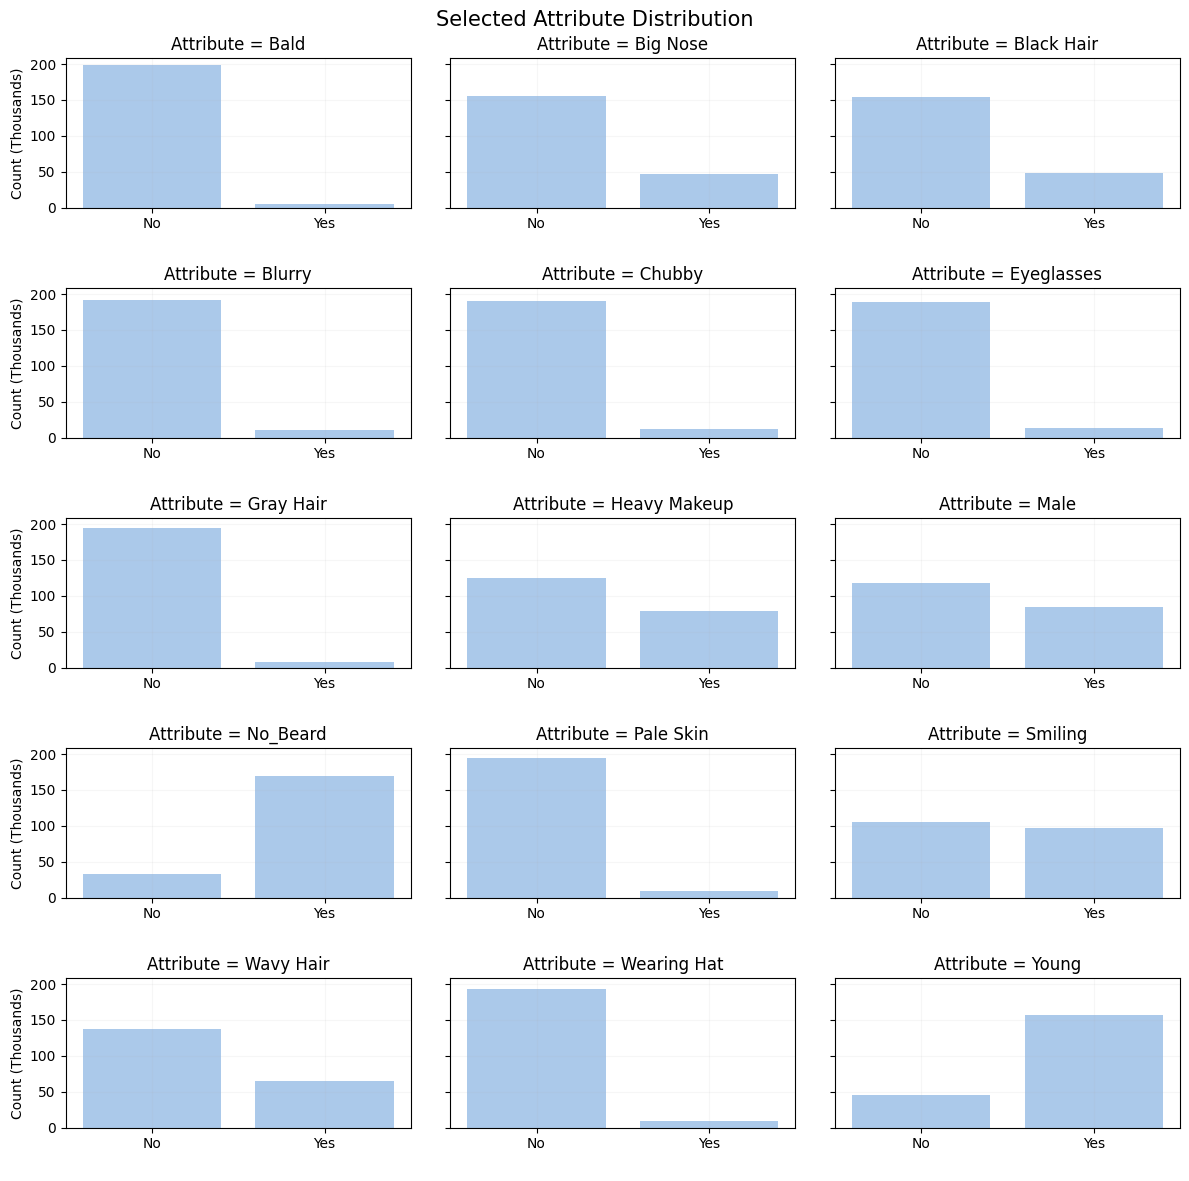

In [28]:
fig, axs = plt.subplots(5, 3, figsize=(12, 12), sharey=True)
axs = axs.ravel()

for i, ax, col, name in zip(range(len(axs)), axs, cols, col_names):
  df_temp = df_attr_subset.groupby([col]).count().iloc[:, 0:1].reset_index()
  index = df_temp.columns[0]
  count = df_temp.columns[1]
  df_temp[count] = df_temp[count] / 1000
  
  sns.barplot(data=df_temp,
            x=index, y=count, color="#a1c9f4", ax=ax)
  ax.set_xlabel(" ")
  if i % 3 == 0:
    ax.set_ylabel("Count (Thousands)")
  else:
    ax.set_ylabel(" ")
  ax.set_title(f"Attribute = {name}")
  ax.grid(alpha=0.1)

plt.suptitle("Selected Attribute Distribution", fontsize=15)
plt.tight_layout()

We observed that the dataset was not balanced on all the attributes. This potential domain shift would be an issue if we were planning to use the model with a subset of celebrities that had a different distribution of the target attribute, so we would need to monitor the performance by at least some of these selected characteristics in order to prevent unfair biases. Furthermore, it is more common to find celebrities who are young, skinny, with pale skin, and without big noses, beards, hats or eyeglasses, to name a few.

Additional noteworthy findings include:
- A considerable amount of celebrities are wearing heavy makeup, something that could negatively impact the model's accuracy.
- The majority of the images are not blurry.

We also analyzed distribution of a few attributes by gender. 

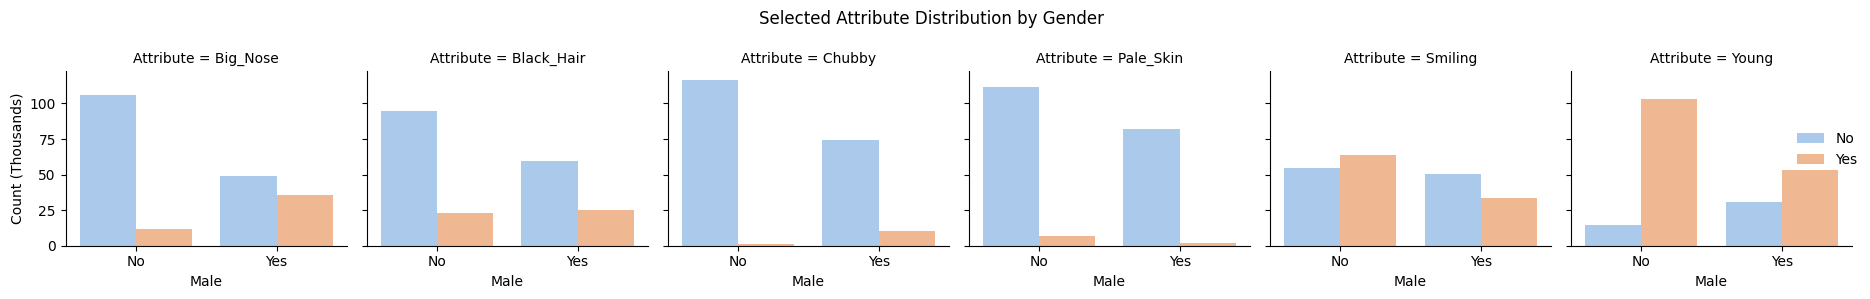

In [29]:
# create dataframe to use with seaborn facet grid
attributes = ["Big_Nose", "Black_Hair", "Chubby", "Pale_Skin", "Smiling", "Young"]

sns_df = pd.DataFrame(columns=["Present", "Male", "Count", "Attribute"])

for att in attributes:
  data = df_attr_subset.groupby([att, "Male"]).count()[["Bald"]].reset_index()
  data["Attribute"] = att
  data.rename(columns={"Bald": "Count", att: "Present"}, inplace=True)
  sns_df = pd.concat([sns_df, data])

# plot of selected attributes by gender
sns_df["Count"] = sns_df["Count"] / 1000
g = sns.FacetGrid(data=sns_df, col="Attribute")
g.map_dataframe(sns.barplot, x="Male", y="Count", hue="Present", palette="pastel")
g.add_legend()
g.axes[0,0].set_ylabel("Count (Thousands)")
plt.suptitle("Selected Attribute Distribution by Gender")
plt.tight_layout()
plt.show()

We found that, for some attributes, the distribution varied significantly by gender. For example:
- While males have a roughly similar number of observations with and without a big nose, only a very small ratio of females has a big nose.
- Although there are very few chubby celebrities for either gender, the ratio between chubby and non-chubby observations is notably smaller for females.
- The ratio between the number of young and old male celebrities is less than 2, while it is almost 7 for women - indicating another yet large disparity in distribution by gender. 

These results could end up affecting the results of our model as some attributes will be underrepresented - an issue that might cause class imbalance. Had we had more time, we would have liked to address this issues and either oversample from the underrepresented classes or manually add celebrity images that contain the underrepresented attributes.

## Modeling Approach

We implemented a Siamese Neural Network for our model. A Siamese NN have become popular in recent years do to their ability to make good predictions from few images. In our model, we used shared parameters $\vec{\theta}$ across the subnetworks and found the similarity of the inputs by comparing their feature vectors.  

We also implemented a self-designed CNN architecture, and trained the model in triplets. These triplets, as their name suggests, consisted of groups of three images:
- An "anchor" image, which we randomly sampled from the dataset.
- An image belonging to the same celebrity as the anchor.
- An image belonging to a celebrity different from the one in the anchor.

A positive pair consists of the anchor and the image belonging to the same celebrity, while a negative pair refers to the anchor and the image of the different celebrity. We then trained the model to minimize the distance between positive pairs and maximize the distance between negative pairs. To maximize this distance, we used a margin $m$ between the two which we tuned as a hyperparameter.

For the loss, we utilize triplet loss, defined as:
$$\mathcal{L}(\theta) = \text{max} \left(||f_\theta(x_\text{anchor}) - f_\theta(x_\text{postive}) || - ||f_\theta(x_\text{anchor}) - f_\theta(x_\text{negative}) || + m, 0 \right)$$.

### Structure of Data
To organize the data, we created a folder per each celebrity, where each folder contains the cropped, resized face images for said celebrity. All folders are stored in the parent folder `celeba_cropped`.

### Image Cropping
As mentioned earlier, the images' size varied significantly so we resized all of them to be $128 \times 128$ pixels and built the folder structure, with each folder named after the celebrity ID, and containing the images associated with that ID. We only considered a subset of celebrities with more than 2 images to ensure we would be able to construct the siamese pairs later on.

In [30]:
RUN = False
if RUN:
    # load identities with bouded boxes from previous section
    url = "https://drive.google.com/file/d/1a2TBOW5lZ7CmL5CVek6KFqTY1j9BxM9S/view?usp=share_link"
    identity_box = "identity_box_cleaned.csv"
    gdown.download(url, identity_box, quiet=False, fuzzy=True)
    identity_box_df = pd.read_csv(identity_box)
    identity_box_df = identity_box_df.loc[~identity_box_df['x1'].isna()].reset_index()

    url = "https://drive.google.com/file/d/1iX62Bp00i62PHpVlsQkMm5TQuXTSW9bl/view?usp=share_link"
    celeb_identity = "list_identity_celeba.txt"
    gdown.download(url, celeb_identity, quiet=False, fuzzy=True)
    celebrity_identity = pd.read_csv(celeb_identity, sep=' ')
    celebrity_identity = celebrity_identity.iloc[:, [0,3]]
    celebrity_identity.rename(columns={'image_id': 'image',	'Unnamed: 3': 'celeb_name'}, inplace=True)

    url = "https://drive.google.com/file/d/1kXi0PlMJ3T7zfRg6seCPjhB0maYLsSE1/view?usp=share_link"
    identity_celebA = "identity_CelebA.txt"
    gdown.download(url, identity_celebA, quiet=False, fuzzy=True)
    identity_df = pd.read_csv(identity_celebA, sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:'image', 1:'ID'})
    identity_df = identity_df.merge(celebrity_identity, how='inner')


    parent = mypath + "Data/celeba_cropped"
    dim = [128, 128]
    ntotal = 0
    for head, group in identity_df.groupby('ID'):
      nimgs = len(group)
      if nimgs > 1:
        nimgs_cropped = 0
        rows = []
        for i in group['image']:
          row = identity_box_df.loc[identity_box_df['image'] == i]
          if len(row) == 1:
            rows.append(row)
            nimgs_cropped += 1
        if nimgs_cropped > 1:
          print(f'writing to folder ID number:{group.ID}')
          child = str(head)
          path = os.path.join(parent, child)
          os.mkdir(path)
          ntotal += 1

          for row in rows:
            image_name = row['image'].item()
            image_path = 'img_celeba/' + image_name
            x1, y1, x2, y2 = int(row['x1'].item()), int(row['y1'].item()), int(row['x2'].item()), int(row['y2'].item())
            image = cv2.imread(image_path)
            cropped = image[y1:y2, x1:x2 , :]
            cropped = cv2.resize(cropped, dim, interpolation = cv2.INTER_AREA)
            print('Cropped shape:', cropped.shape)
            cv2_imshow(cropped)
            cv2.imwrite(str(path+'/'+image_name), cropped)
    
      if ntotal > 1200:
        break

### Final Model

First, we created a number of helper functions that will be useful throughout our later work.

In [31]:
# Setting random seeds to enable consistency while testing
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

# Download preprocessed images if needed
url = "https://drive.google.com/file/d/1M9rEXECct6a5xZPTf9js_VqGfR8gp8mY/view?usp=share_link"
output = "celeba_cropped.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

!unzip celeba_cropped.zip > /dev/null

# set root directory
ROOT = "celeba_cropped"

# helper function to read images
def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# helper function to split dataset into train and test
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

# helper function to find a negative image
def find_negative(directory, anchor, folders, max_files=10):
  folder = ()
  files = []

  # loop until finding a folder with images
  while (len(files) < 1) or anchor == folder:
    folder = random.choice(folders)
    path = os.path.join(directory, folder)
    files = list(os.listdir(path))[:max_files]

  neg_file = random.choice(files)
  negative = (folder, neg_file)
  return negative

# helper function to create triplets of images
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])
                neg_folder = folder
                negative = find_negative(directory, anchor, folders)
                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

# helper function to obtain a batch of images
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

Downloading...
From: https://drive.google.com/uc?id=1M9rEXECct6a5xZPTf9js_VqGfR8gp8mY
To: /content/celeba_cropped.zip
100%|██████████| 40.1M/40.1M [00:01<00:00, 34.6MB/s]


We then split a subset of celebrities into train and test lists. Each list contains the folder name for the celebrities' pictures and the number of images in the folder.

In [32]:
train_list, test_list = split_dataset(ROOT, split=0.9)

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)


Test List: {'577': 7, '697': 4, '122': 6, '344': 6, '363': 4, '412': 2, '109': 6, '692': 7, '1143': 3, '1320': 5, '234': 5, '290': 8, '509': 6, '1106': 4, '1369': 2, '963': 6, '258': 6, '555': 8, '1228': 5, '128': 5, '563': 9, '185': 2, '946': 3, '1252': 7, '1004': 2, '1057': 5, '781': 2, '757': 3, '660': 3, '264': 4, '886': 4, '875': 4, '393': 3, '382': 5, '64': 6, '283': 3, '919': 2, '78': 5, '1016': 4, '1396': 2, '1250': 5, '938': 3, '821': 2, '1113': 7, '1233': 2, '1247': 6, '228': 3, '455': 5, '1065': 4, '189': 4, '933': 2, '414': 3, '634': 2, '1154': 5, '991': 2, '192': 4, '17': 3, '1146': 7, '984': 7, '1223': 6, '790': 5, '66': 3, '1149': 5, '487': 7, '432': 3, '235': 9, '1313': 6, '501': 2, '458': 6, '1226': 6, '1341': 7, '546': 4, '67': 3, '1375': 3, '705': 4, '1121': 4, '486': 3, '438': 5, '855': 3, '1043': 5, '1352': 3, '25': 4, '1362': 4, '1159': 2, '463': 7, '324': 4, '623': 4, '730': 4, '525': 5, '814': 3, '924': 7, '444': 6, '1046': 4, '685': 5, '722': 3, '1325': 3, '29

Afterwards, we created triplets from the train and tests lists.

In [33]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

The plot below depicts an example of six triplets from the train set.

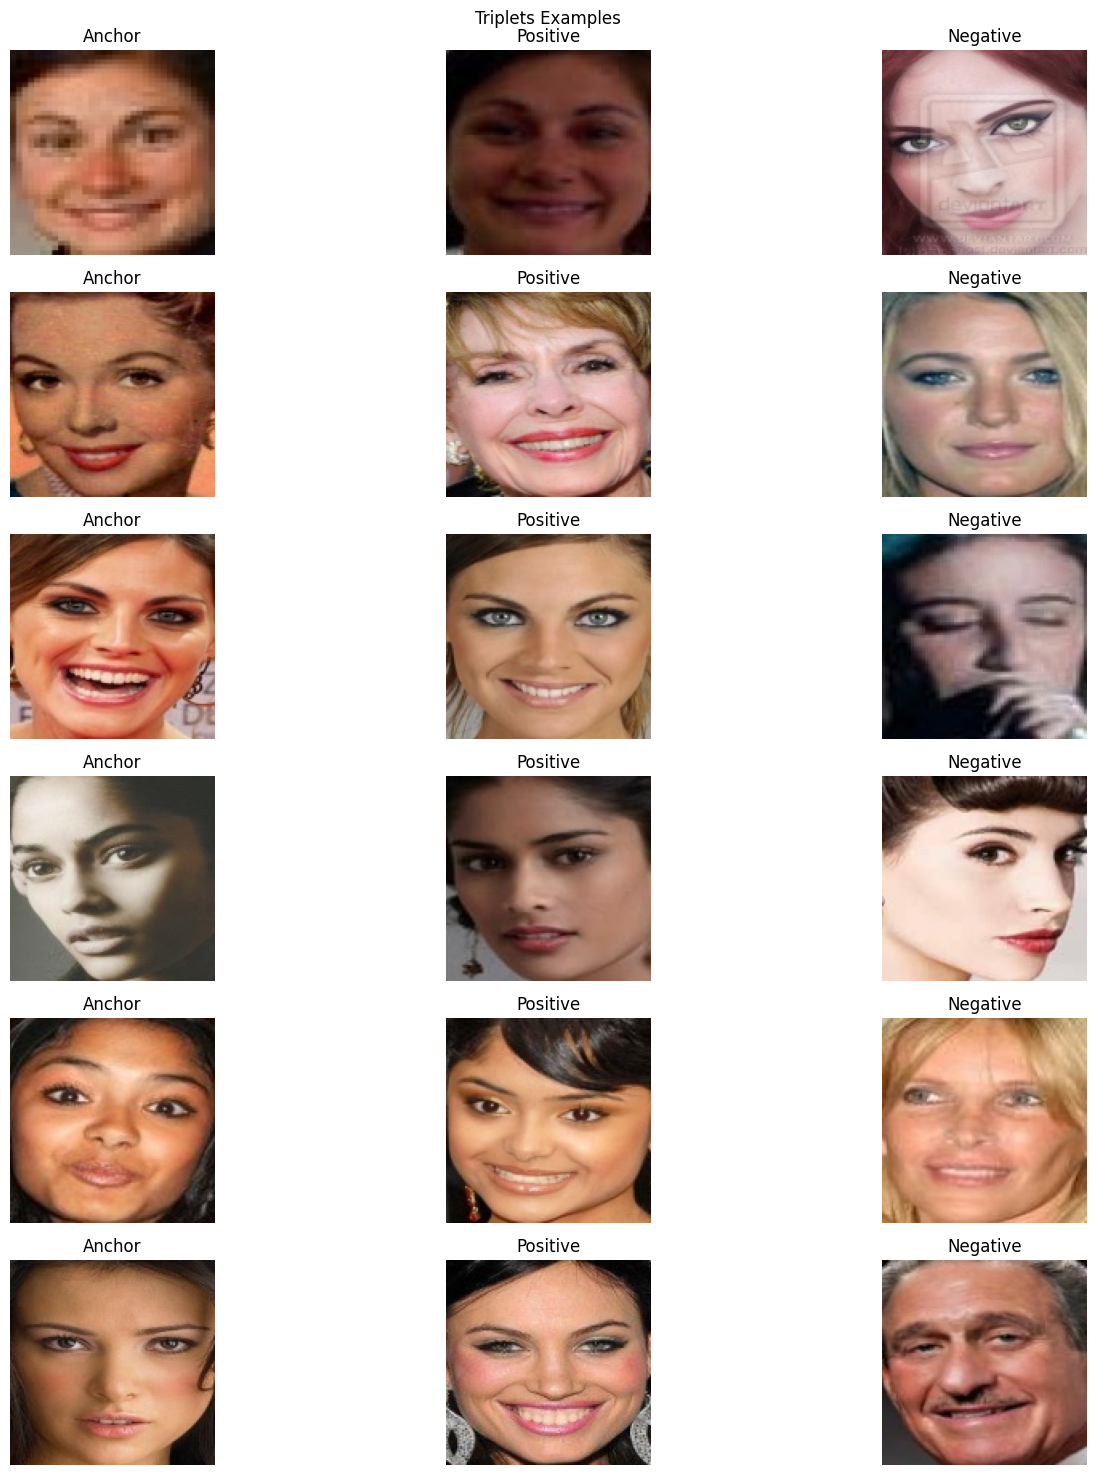

In [34]:
num_plots = 6
fig, axes = plt.subplots(num_plots, 3, figsize=(15, 15))

# obtain batch of 6 triplets and display them
for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    anchor, pos, neg = x
    for i in range(num_plots):
        axes[i, 0].imshow(anchor[i])
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Anchor")
        axes[i, 1].imshow(pos[i])
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Positive")
        axes[i, 2].imshow(neg[i])
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Negative")
        i+=1
    break

plt.suptitle("Triplets Examples")
plt.tight_layout();

To build the model, we started with the base model architecture using the following steps:

1. First, we built the encoder. 
 - For this part, we took advantage of transfer learned and used the Xception convolutional neural network. Xception is 71 layers deep and has been pretrained on more than a million images from ImageNet.
 - We obtained the best results by freezing the first 44 layers and re-training on the last 27. 
 - We then added a few extra layers on top to suit the network to our intended task.

2. Our model contains three input layers: one for the anchor, one for the positive image, and one for the negative image. Using these with the encoder layer, we were able to generate encodings for each of the inputs. 

3. We then added a customized distance layer to calculate the distances between the anchor and the positive image and the anchor and the negative image. 

4. We trained the model to minimize the distance between the positive pair, maximize the distance between the negative pair, and maximize the distance between these two.

In [60]:
# Define the image encoding model using three different backbones
def get_encoder_MobileNetV2(input_shape):
  base_model = MobileNetV2(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet')

  model = Sequential([base_model,
                      layers.Flatten(),
                      layers.Dense(512, activation='relu'),
                      layers.BatchNormalization(),
                      layers.Dense(256, activation='relu'),
                      layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))], name="Embedding")

  return model

def get_encoder_Xception(input_shape):
    base_model = Xception(input_shape=input_shape,
                          weights='imagenet',
                          include_top=False,
                          pooling='avg')
    
    for i in range(len(base_model.layers)-27):
        base_model.layers[i].trainable = False

    model = Sequential([base_model,
                      layers.Flatten(),
                      layers.Dense(512, activation='relu'),
                      layers.BatchNormalization(),
                      layers.Dense(256, activation='relu'),
                      layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))], name="Embedding")

    return model

def get_encoder_ResNet50(input_shape):
  base_model = resnet.ResNet50(weights="imagenet",
                               input_shape=input_shape,
                               include_top=False,
                               pooling='avg')

  for i in range(len(base_model.layers)-35):
        base_model.layers[i].trainable = False

  model = Sequential([base_model,
                    layers.Flatten(),
                    layers.Dense(512, activation='relu'),
                    layers.BatchNormalization(),
                    layers.Dense(256, activation='relu'),
                    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))], name="Embedding")

  return model

class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

# Construct Siamese network model
def get_siamese_network(input_shape = (128, 128, 3), base_model='xception'):
    if base_model == 'xception':
      encoder = get_encoder_Xception(input_shape)
    elif base_model == 'resnet50':
      encoder = get_encoder_ResNet50(input_shape)
    elif base_model == 'mobilenet':
      encoder = get_encoder_MobileNetV2(input_shape)
    else:
      raise('Invalid encoder type')
    
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

Base Model Architecture


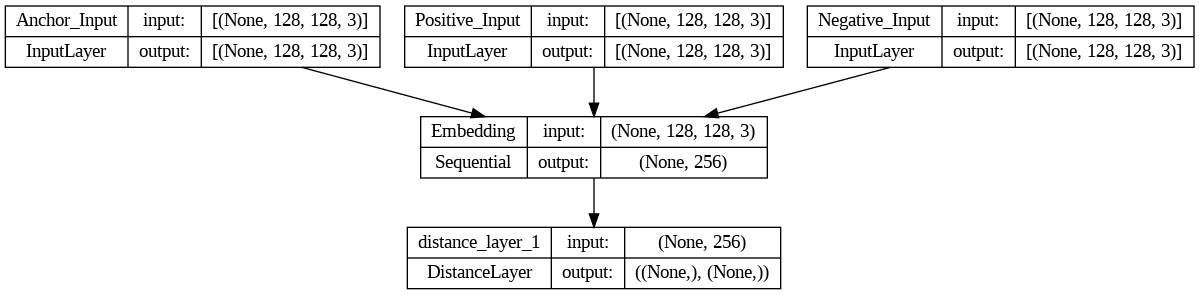

In [61]:
print(f"Base Model Architecture")
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

The model $f_\theta$ built previously receives as input an image $x$, and outputs the correponding embedding $f_\theta(x)$. Our Siamese Network is built on top of that, by receiving a triplet $(x_\text{anchor}, x_\text{positive}, x_\text{negative})$ as input, computing the embeddings for each image using $f_\theta$ and outputing $||f_\theta(x_\text{anchor}) - f_\theta(x_\text{positive})||$ and $||f_\theta(x_\text{anchor}) - f_\theta(x_\text{negative})||$

In [62]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [63]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

After having built the full model, we were ready to train it on the train set. The training process is very slow to due to the large amount of data, so we saved the weights and re-loaded them in subsequent runs. 

In [64]:
# helper function to test Siamese model on triplets
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

RUN = False
if RUN:
  save_all = False
  epochs = 256
  batch_size = 128

  max_acc = 0
  train_loss = []
  test_metrics = []

  # Run for epochs
  for epoch in range(1, epochs+1):
      t = time.time()
      
      # Training the model on train data
      epoch_loss = []
      for data in get_batch(train_triplet, batch_size=batch_size):
          loss = siamese_model.train_on_batch(data)
          epoch_loss.append(loss)
      epoch_loss = sum(epoch_loss)/len(epoch_loss)
      train_loss.append(epoch_loss)

      print(f"Loss on train    = {epoch_loss:.5f}")
      
      # Testing the model on test data
      metric = test_on_triplets(batch_size=batch_size)
      test_metrics.append(metric)
      accuracy = metric[0]
      
      # Saving the model weights
      if save_all or accuracy>=max_acc:
          siamese_model.save_weights(mypath + "Model/siamese_model_celeba.h5")
          max_acc = accuracy

  # Saving the model after all epochs run
  siamese_model.save_weights(mypath + "Model/siamese_model-final_celeba.h5")

In [40]:
# Build model 
siamese_model.built = True

# Get weights
url = "https://drive.google.com/file/d/1-inkNCciQ2WEydTor89psqL_GsEz5qZr/view?usp=share_link"
output = "siamese_model_celeba.h5"
gdown.download(url, output, quiet=False, fuzzy=True)
siamese_model.load_weights("siamese_model_celeba.h5")

Downloading...
From: https://drive.google.com/uc?id=1-inkNCciQ2WEydTor89psqL_GsEz5qZr
To: /content/siamese_model_celeba.h5
100%|██████████| 88.4M/88.4M [00:02<00:00, 39.1MB/s]


### Results
Afterwards, we proceeded to evaluate the model on the test data. To do this, we first extracted the encoder from the Siamese model, which returns an embedding for a given image.

In [66]:
def extract_encoder(model):
    encoder = get_encoder_Xception((128, 128, 3))
    for i, e_layer in enumerate(model.layers[0].layers[3].layers):
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")

Then, we obtained a bach of 256 triplets to test, found the embeddings for each image using the encoder, and calculated the distances between the positive and negative pairs. 

In [42]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for given passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    # Calculating distance between given faces
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

# lists to store positive and negative test pairs
pos_list = np.array([])
neg_list = np.array([])

# obtain a batch of triplets to test
for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

8/8 [==============================] - 0s 34ms/step


The model did a very good job at identifying which images "belonged" together and which did not. In other words, it was able to accurately predict whether a given positive pair of images was more similar than the negative pair of images. The resulting test accuracy was above 90%.

In [43]:
true = np.array([0]*len(pos_list) + [1]*len(neg_list))
pred = np.append(pos_list, neg_list)
acc = np.mean(true == pred)
print(f"The test accuracy is {acc*100:.2f}%")

The test accuracy is 72.27%


We then tested the model's ability to perform in-the-wild facial recognition. In this case, the model compared the similarity of a given image's embedding against the embedding of every other picture in the dataset, and returned the celebrity with the closest embedding (i.e. the celebrity whose face looked the most similar to the one in the given image).

In [44]:
# Helper functions to pre-process images

# Normalize image
def preprocess_prediction(image):
    image = image.astype(np.float32)
    image = image/255.0
    return image

def preprocess_prediction_image_path(file_path, image_height=128, image_width=128):
    # Read image
    image = cv2.imread(file_path)
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Reshape
    image = cv2.resize(image, (image_height, image_width), interpolation=cv2.INTER_AREA)
    return preprocess_prediction(image).reshape((1, image_width, image_height, 3))

# Obtain embeddings for all images
def load_faces(paths, model, faces_embedding):
    for face_db_path in paths:
        if not os.path.exists(face_db_path):
            raise FileNotFoundError('Face database path not found!')
        for root, dirs, files in os.walk(face_db_path):
            for file_ in files:
                if '.jpeg' in file_ or '.jpg' or '.png' in file_:
                    img_path = face_db_path+'/'+file_
                    input_image = preprocess_prediction_image_path(img_path)
                    user_name = file_.split(".")[0]
                    embedding = model.predict(input_image, verbose=0)
                    faces_embedding.append({
                        "user_name": user_name,
                        "embedding": embedding
                    })
    return faces_embedding

First, we followed multiple pre-processing steps, including normalization, RBG conversion, and reshaping so all images were of the same size. We then obtained embeddings for all images and stored them in a dataframe.

In [45]:
# NOTE: takes a while to run
folders = glob('celeba_cropped/*')

# Obtain embeddings
celebA_faces = {folders[i].split('/')[-1]: load_faces([folders[i]], encoder, []) for i in tqdm(range(len(folders)))}

# Change format to df
celebA_faces_df = pd.DataFrame.from_dict({(i,j): celebA_faces[i][j] 
                          for i in celebA_faces.keys() 
                          for j in range(len(celebA_faces[i]))},
                      orient='index').reset_index()
celebA_faces_df.rename(columns={'level_0':'id', 'level_1': 'img_idx', 'user_name': 'img_name'}, inplace=True)

# Unpack embeddings
celebA_faces_df['embedding'] = celebA_faces_df['embedding'].apply(lambda x: np.squeeze(x))

100%|██████████| 1201/1201 [06:16<00:00,  3.19it/s]


We also built a dataframe with the IDs for the celebrities that we used in the test set and created a custom cosine similarity function to obtain the average similarity by celebrity. 

In [46]:
# obtain test IDs
DOWNLOAD = False
if DOWNLOAD:
    # Or download test ids if needed
    url = "https://drive.google.com/file/d/1W-f_VpYwGBmUC9KcHN94KGViy8JaEmEe/view?usp=sharing"
    output = "test_ids.csv"
    gdown.download(url, output, quiet=False, fuzzy=True)
    test_ids = pd.read_csv("test_ids.csv")

else:
    # Format test ids from previous section
    test_ids = pd.DataFrame(test_list.keys())

# Rename column
test_ids.rename(columns={0:'id'}, inplace=True)

In [47]:
# Custom cosine similarity to obtain average similarity by celebrity
def cosine_similarity_byid(img_embedding, df, exclude=None):
    avg_cosine_similarities = {}
    for head, group in df.groupby('id')[['id','img_name','embedding']]:
        # cosine similarity for all rows in group, with option to exclude
        cs = cosine_similarity(img_embedding, np.array([i for i in group[~group.img_name.isin([exclude])]['embedding']]))
        # average cosine similarity for group
        avg_cosine_similarities[int(head)] = np.mean(cs)
    return avg_cosine_similarities

Lastly, we evaluated the model by identifying the celebrity in the dataset with the closest embedding to that of the given image, and checking whether the prediction was accurate. 

In [48]:
avg_cosine_similarities = {}
total = []
unique_imgs = sorted(list(set(celebA_faces_df.img_name)))
test_imgs = celebA_faces_df[celebA_faces_df['id'].isin([str(i) for i in list(test_ids['id'])])].img_name

for i in tqdm(test_imgs):
    # get image embedding by name
    img_embedding = np.array(celebA_faces_df[celebA_faces_df['img_name'] == i]['embedding'])[0].reshape(1,-1)
    # cosine similarities by group, excluding itself
    avg_cosine_similarities = cosine_similarity_byid(img_embedding, celebA_faces_df, i)
    # id of the group with highest similarity 
    max_id = max(avg_cosine_similarities, key=avg_cosine_similarities.get)
    # pair of id with it's closest id
    current_id = int(celebA_faces_df[(celebA_faces_df['img_name'] == i)]['id'].item())
    # trace of correct/incorrect for all images
    total.append(max_id == current_id)

100%|██████████| 559/559 [11:31<00:00,  1.24s/it]


The accuracy significantly reduced in this task, reaching ~14% on the test set.

In [ ]:
print(f"Facial Recognition accuracy on test images: {round(sum(total)*100/len(total), 2)}%")

To try to find out where and why our model is making mistakes, we investigated further and examined some of the correctly and incorrectly classified examples. However, we did not find any patterns in our analysis.

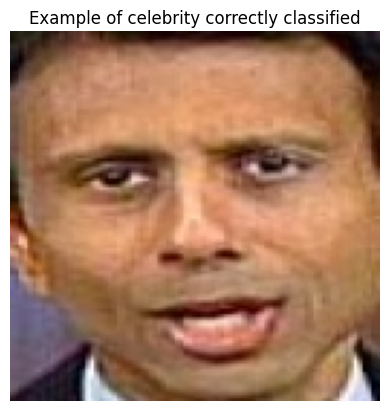

In [56]:
# show correctly classified image
corrects = test_imgs[[i for i in total]]
img_name = corrects.iloc[0]
img_select = celebA_faces_df[celebA_faces_df['img_name'] == img_name]
image_path = 'celeba_cropped/' + img_select.id.item() +'/' + img_name + '.jpg'
img =  cv2.imread(image_path)[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.title('Example of celebrity correctly classified');

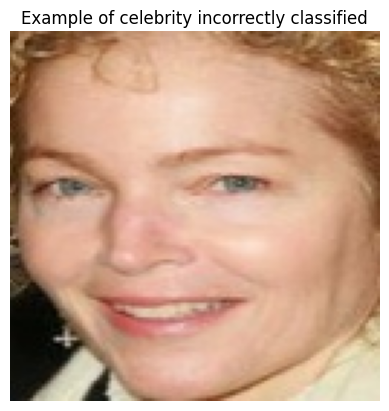

In [57]:
# show incorrectly classified image
incorrects = test_imgs[[not i for i in total]]
img_name = incorrects.iloc[0]
img_select = celebA_faces_df[celebA_faces_df['img_name'] == img_name]
image_path = 'celeba_cropped/' + img_select.id.item() +'/' + img_name + '.jpg'
img =  cv2.imread(image_path)[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.title('Example of celebrity incorrectly classified');

## Conclusion and Future Work

Our model to perform celebrity face detection with computer vision was able to replicate the Amazon Prime Video feature identifying actors appearing in the image of a paused scene, albeit there are some caveats. 

We found that the answer to the question we raised earlier in the semester and stated at the beginning of the notebook ("is it possible to utilize transfer learning to develop our own facial recognition model capable of accurately categorizing celebrity faces sourced from the CelebA dataset?") is ambiguous. Although we were indeed able to make use of transfer learning to develop a facial recognition model capable of categorizing celebrity faces sourced from the CelebA dataset, the resulting facial recognition model we obtained did not achieve a particularly high accuracy. 

Specifically, when the model was given one image and had to determine which celebrity present in the dataset looked most similar to the person in the given image, the accuracy was ranged from 13 to 17% across multiple runs. In our last run, its value was slightly above 14%. 

Although we examined both correctly and incorrectly classified images to try to identity patterns in the model's predictions, we were unable to find any patterns. Therefore, it is not clear to us why exactly the accuracy was so low, but we have several hypothesis:

1. It might have been helpful to perform data augmentation. We originally aimed to manually add more pictures for the $44$ celebrities that were present in a single image and to do further augmentation by adding noise and flipping. However, due to time constraints, we were forced to skip this step.
2. Some of the negative pairs might have been too easy for the model. We would have liked to experiment with making the negative image more similar to the positive one so that the model got better at identifying what precisely made a given celebrity unique. For instance, in some cases the target image depicted a light-skinned person, while the negative image showed a dark-skinned one. Cases like this might have ended up harming the model's accuracy in the long-term by not allowing it to learn how to move the embedding of the anchor away from the embedding of the negative image. 
3. Due to limited computational resources, we used a small subset of the celebA dataset to train the model, which might have impacted the results.
4. We trained on relatively few epochs because of time and resource constraints. However, training on more epochs might have allowed the model to obtain a higher accuracy. 

On the other hand, the model performed very well for different yet related task. When given a set of two images and deciding whether the images belonged to the same celebrity or not, the accuracy obtained was above 90% 

In this case, we believe the remarkably good results may have been caused by a number of factors including:
1. We trained on many epochs.
2. The triplets we used to evaluate the model contained negative pairs that presented significant differences and thus made it easier for the network to identify the embedding that minimized the loss and return the correct classification. 
3. It is an easier task to be given two images and determine whether they are similar than to be given a single image and find which of the thousands of celebrities in the underlying dataset it may belong to. 

In the future, we would like to be able to use a larger portion of the dataset, or even a bigger dataset, as we strongly believe this will improve the accuracy of the model. We would also like to implement data augmentation and to find a way to construct the triplets that enables the model to learn better.  

Lastly, we would like to explore more model architectures and loss functions. We experimented with different backbones including ResNet50, MobileNetV2 and Xception, and noticed the results would vary significantly based on the underlying backbone and loss used. Therefore, we believe tweaking with these would add nuch room for improvement in the results. 

Although we would have liked to obtain a higher accuracy, we greatly enjoyed working on this project throughout the semester. It was an outstanding learning experience that allowed us to get out of our comfort zones, put into practice many of the advanced topics we covered in class, experiment with topics, architectures and concepts we had never encountered before, and apply our knowledge and enthusiasm for data science to build a feature based on a real-life application by the biggest streaming platform that is used by millions around the world.

## References

Li, J. (2018) Celebfaces attributes (celeba) dataset, Kaggle. Available at: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset (Accessed: 10 Mar 2023). 

Stoicstatic (2021) Face recognition: Siamese w/ Triplet Loss, Kaggle. Available at: https://www.kaggle.com/code/stoicstatic/face-recognition-siamese-w-triplet-loss/notebook (Accessed: 01 May 2023). 


Team, K. (no date) Keras Documentation: Image similarity estimation using a Siamese network with a triplet loss, Keras. Available at: https://keras.io/examples/vision/siamese_network/ (Accessed: 03 Apr 2023). 
